# Mod 5 Project - Using Machine Learning to Predict Coronavirus

This project uses daily updated coronavirus data from John Hopkins Hospital

### STEP 1: IMPORT ALL NECCESSARY LIBRARIES

In [1]:
# import all neccessary libraries
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import numpy as np
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import itertools

sns.set_style('whitegrid')
plt.style.use('ggplot')

# ignore all harmless waring to keep the notebook clean
warnings.filterwarnings('ignore')

# keep the plot inline in notebookb
%matplotlib inline

### STEP 2: LOAD DATA
#### We have 3 data sets: Confirmed cases, Death cases & Recovered cases

In [2]:
# load data
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
df_confirmed = pd.read_csv(url + 'time_series_19-covid-Confirmed.csv')
df_deaths = pd.read_csv(url + 'time_series_19-covid-Deaths.csv')
df_recovered = pd.read_csv(url + 'time_series_19-covid-Recovered.csv')

In [3]:
df_population_K = pd.read_csv('population_by_country_2020.csv')
df_population_K.head()

,Country (or dependency),Population (2020),Yearly Change,Net Change,Density (P/Km²),Land Area (Km²),Migrants (net),Fert. Rate,Med. Age,Urban Pop %,World Share
0,China,1439323776,0.39%,5540090,153,9388211,-348399.0,1.7,38,61%,18.47%
1,India,1380004385,0.99%,13586631,464,2973190,-532687.0,2.2,28,35%,17.70%
2,United States,331002651,0.59%,1937734,36,9147420,954806.0,1.8,38,83%,4.25%
3,Indonesia,273523615,1.07%,2898047,151,1811570,-98955.0,2.3,30,56%,3.51%
4,Pakistan,220892340,2.00%,4327022,287,770880,-233379.0,3.6,23,35%,2.83%


In [4]:
df_population_K.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235 entries, 0 to 234
Data columns (total 11 columns):
Country (or dependency)    235 non-null object
Population (2020)          235 non-null int64
Yearly Change              235 non-null object
Net Change                 235 non-null int64
Density (P/Km²)            235 non-null int64
Land Area (Km²)            235 non-null int64
Migrants (net)             201 non-null float64
Fert. Rate                 235 non-null object
Med. Age                   235 non-null object
Urban Pop %                235 non-null object
World Share                235 non-null object
dtypes: float64(1), int64(4), object(6)
memory usage: 20.3+ KB


In [5]:
df_2020_K = df_population_K.filter(['Country (or dependency)', 'Population (2020)'])
df_2020_K.reset_index(inplace=True)
df_2020_K.drop(['index'], axis=1, inplace=True)
df_2020_K.head()


,Country (or dependency),Population (2020)
0,China,1439323776
1,India,1380004385
2,United States,331002651
3,Indonesia,273523615
4,Pakistan,220892340


### STEP 3: INITIAL EXPLORATORY DATA ANALYSIS - EDA:

### A/ INITIAL ANALYSIS - df_confirmed

In [6]:
df_confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,70,75,82,114,147,177,212,272,322,411
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,639,701,773,839,825,878,889,924,963,1007
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,178,200,212,226,243,266,313,345,385,432
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,149,197,238,428,566,673,790,900,1030,1183


In [7]:
df_confirmed.tail()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
477,Northwest Territories,Canada,64.8255,-124.8457,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
478,NaN,Cape Verde,15.1111,-23.6167,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
479,NaN,East Timor,-8.5500,125.5600,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
480,NaN,Eritrea,15.1794,39.7823,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
481,NaN,Uganda,1.0000,32.0000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [8]:
df_confirmed.describe(include=['object', 'bool'])

,Province/State,Country/Region
count,325,482
unique,323,166
top,Diamond Princess,US
freq,2,247


In [9]:
df_confirmed.describe()

,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
count,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,...,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000
mean,30.826006,-34.110289,1.151452,1.354772,1.952282,2.975104,4.394191,6.072614,11.572614,12.792531,...,266.271784,301.230290,323.846473,347.398340,376.612033,409.008299,445.871369,503.543568,564.659751,631.792531
std,19.504038,81.009331,20.274619,20.358039,25.359285,35.310671,49.362150,66.518790,163.026623,164.090876,...,3194.286424,3265.206784,3326.553853,3397.511937,3481.547181,3579.433870,3712.599681,3906.666957,4142.112667,4420.296200
min,-41.454500,-157.858400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.114425,-92.183250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,37.589700,-73.994500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,2.000000,3.000000,3.000000,4.000000
75%,42.216825,21.758700,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,12.000000,17.750000,26.000000,32.000000,40.500000,57.500000,69.500000,84.000000,93.750000,127.500000
max,71.706900,178.065000,444.000000,444.000000,549.000000,761.000000,1058.000000,1423.000000,3554.000000,3554.000000,...,67781.000000,67786.000000,67790.000000,67794.000000,67798.000000,67799.000000,67800.000000,67800.000000,67800.000000,67800.000000


In [10]:
# count the null columns
null_columns = df_confirmed.columns[df_confirmed.isnull().any()]
df_confirmed[null_columns].isnull().sum().head()

Province/State    157
dtype: int64

In [11]:
# glance look at the null data
pd.set_option('display.max_columns', 999)
print(df_confirmed[df_confirmed.isnull().any(axis=1)][null_columns].head())

  Province/State
0            NaN
1            NaN
2            NaN
3            NaN
4            NaN


In [12]:
# glance look at the null data
pd.set_option('display.max_rows', 999)
print(df_confirmed[df_confirmed.isnull().any(axis=1)][null_columns])

    Province/State
0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
9              NaN
10             NaN
11             NaN
12             NaN
13             NaN
14             NaN
15             NaN
16             NaN
17             NaN
18             NaN
20             NaN
21             NaN
23             NaN
24             NaN
25             NaN
26             NaN
27             NaN
28             NaN
29             NaN
30             NaN
31             NaN
32             NaN
33             NaN
34             NaN
35             NaN
36             NaN
37             NaN
38             NaN
39             NaN
40             NaN
41             NaN
42             NaN
43             NaN
44             NaN
45             NaN
46             NaN
47             NaN
48             NaN
50             NaN
51             NaN
52             NaN
53             NaN
54             NaN
55             NaN
56             NaN
57             NaN
58          

In [13]:
len(df_confirmed['Province/State'].unique())

324

In [14]:
print(df_confirmed['Province/State'].unique())

[nan 'British Columbia' 'New South Wales' 'Victoria' 'Queensland'
 'South Australia' 'From Diamond Princess' 'Western Australia' 'Tasmania'
 'Northern Territory' 'Ontario' 'Alberta' 'Quebec' 'Washington' 'New York'
 'California' 'Massachusetts' 'Diamond Princess' 'Grand Princess'
 'Georgia' 'Colorado' 'Florida' 'New Jersey' 'Oregon' 'Texas' 'Illinois'
 'Pennsylvania' 'Iowa' 'Maryland' 'North Carolina' 'South Carolina'
 'Tennessee' 'Virginia' 'Arizona' 'Indiana' 'Kentucky'
 'District of Columbia' 'Nevada' 'New Hampshire' 'Minnesota' 'Nebraska'
 'Ohio' 'Rhode Island' 'Wisconsin' 'Connecticut' 'Hawaii' 'Oklahoma'
 'Utah' 'Kansas' 'Louisiana' 'Missouri' 'Vermont' 'Alaska' 'Arkansas'
 'Delaware' 'Idaho' 'Maine' 'Michigan' 'Mississippi' 'Montana'
 'New Mexico' 'North Dakota' 'South Dakota' 'West Virginia' 'Wyoming'
 'Hubei' 'France' 'Guangdong' 'Henan' 'Zhejiang' 'Hunan' 'Anhui' 'Jiangxi'
 'Shandong' 'Jiangsu' 'Chongqing' 'Sichuan' 'Heilongjiang' 'Denmark'
 'Beijing' 'Shanghai' 'Hebei' 'Fuji

In [15]:
len(df_confirmed['Country/Region'].unique())

166

In [16]:
print(df_confirmed['Country/Region'].unique())

['Thailand' 'Japan' 'Singapore' 'Nepal' 'Malaysia' 'Canada' 'Australia'
 'Cambodia' 'Sri Lanka' 'Germany' 'Finland' 'United Arab Emirates'
 'Philippines' 'India' 'Italy' 'Sweden' 'Spain' 'Belgium' 'Egypt'
 'Lebanon' 'Iraq' 'Oman' 'Afghanistan' 'Bahrain' 'Kuwait' 'Algeria'
 'Croatia' 'Switzerland' 'Austria' 'Israel' 'Pakistan' 'Brazil' 'Georgia'
 'Greece' 'North Macedonia' 'Norway' 'Romania' 'Estonia' 'San Marino'
 'Belarus' 'Iceland' 'Lithuania' 'Mexico' 'New Zealand' 'Nigeria'
 'Ireland' 'Luxembourg' 'Monaco' 'Qatar' 'Ecuador' 'Azerbaijan' 'Armenia'
 'Dominican Republic' 'Indonesia' 'Portugal' 'Andorra' 'Latvia' 'Morocco'
 'Saudi Arabia' 'Senegal' 'Argentina' 'Chile' 'Jordan' 'Ukraine' 'Hungary'
 'Liechtenstein' 'Poland' 'Tunisia' 'Bosnia and Herzegovina' 'Slovenia'
 'South Africa' 'Bhutan' 'Cameroon' 'Colombia' 'Costa Rica' 'Peru'
 'Serbia' 'Slovakia' 'Togo' 'Malta' 'Martinique' 'Bulgaria' 'Maldives'
 'Bangladesh' 'Paraguay' 'Albania' 'Cyprus' 'Brunei' 'US' 'Burkina Faso'
 'Holy See'

### B/ INITIAL ANALYSIS - df_deaths

In [17]:
df_deaths.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
0,NaN,Thailand,15.0000,101.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,NaN,Japan,36.0000,138.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,2,4,4,5,6,6,6,6,6,6,6,6,10,10,15,16,19,22,22,27,29,29,29,33,35
2,NaN,Singapore,1.2833,103.8333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,NaN,Nepal,28.1667,84.2500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,NaN,Malaysia,2.5000,112.5000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,3,4


In [18]:
df_deaths.tail()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
477,Northwest Territories,Canada,64.8255,-124.8457,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
478,NaN,Cape Verde,15.1111,-23.6167,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
479,NaN,East Timor,-8.5500,125.5600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
480,NaN,Eritrea,15.1794,39.7823,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
481,NaN,Uganda,1.0000,32.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
df_deaths.describe(include=['object', 'bool'])

,Province/State,Country/Region
count,325,482
unique,323,166
top,Diamond Princess,US
freq,2,247


In [20]:
df_deaths.describe()

,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
count,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.00000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000
mean,30.826006,-34.110289,0.035270,0.037344,0.053942,0.087137,0.116183,0.170124,0.271784,0.275934,0.354772,0.441909,0.537344,0.751037,0.883817,1.020747,1.170124,1.315353,1.491701,1.672199,1.879668,2.101660,2.309129,2.319502,2.844398,3.159751,3.456432,3.672199,3.875519,4.16390,4.402490,4.661826,4.670124,5.099585,5.122407,5.454357,5.618257,5.746888,5.838174,5.958506,6.101660,6.215768,6.400415,6.556017,6.751037,6.946058,7.178423,7.381743,7.887967,8.273859,8.842324,9.574689,9.792531,11.211618,12.072614,13.360996,14.784232,16.400415,18.118257,20.470954,23.441909,26.914938
std,19.504038,81.009331,0.774329,0.775573,1.094873,1.822897,2.369897,3.462916,5.694108,5.694638,7.379853,9.292529,11.341956,15.942081,18.857023,21.817510,25.005698,28.148554,31.837832,35.527396,39.672438,44.363787,48.645541,48.645666,59.668093,66.364029,72.695211,77.249524,81.486023,87.49881,92.417451,97.654551,97.654324,106.854295,106.854184,113.640783,116.738738,119.107851,120.295110,122.166421,124.223727,125.781991,127.718112,129.211643,130.909263,132.418591,133.894509,135.323127,137.261696,138.982910,141.250813,144.578920,145.430319,152.688345,157.229380,166.473295,176.807397,188.630295,204.825387,221.663040,246.501369,279.343921
min,-41.454500,-157.858400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.114425,-92.183250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,37.589700,-73.994500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

In [21]:
# count the null columns
null_columns = df_deaths.columns[df_deaths.isnull().any()]
df_deaths[null_columns].isnull().sum().head()

Province/State    157
dtype: int64

In [22]:
# glance look at the null data
pd.set_option('display.max_columns', 999)
print(df_deaths[df_deaths.isnull().any(axis=1)][null_columns].head())

  Province/State
0            NaN
1            NaN
2            NaN
3            NaN
4            NaN


In [23]:
# glance look at the null data
pd.set_option('display.max_rows', 999)
print(df_deaths[df_deaths.isnull().any(axis=1)][null_columns])

    Province/State
0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
9              NaN
10             NaN
11             NaN
12             NaN
13             NaN
14             NaN
15             NaN
16             NaN
17             NaN
18             NaN
20             NaN
21             NaN
23             NaN
24             NaN
25             NaN
26             NaN
27             NaN
28             NaN
29             NaN
30             NaN
31             NaN
32             NaN
33             NaN
34             NaN
35             NaN
36             NaN
37             NaN
38             NaN
39             NaN
40             NaN
41             NaN
42             NaN
43             NaN
44             NaN
45             NaN
46             NaN
47             NaN
48             NaN
50             NaN
51             NaN
52             NaN
53             NaN
54             NaN
55             NaN
56             NaN
57             NaN
58          

In [24]:
len(df_deaths['Province/State'].unique())

324

In [25]:
print(df_deaths['Province/State'].unique())

[nan 'British Columbia' 'New South Wales' 'Victoria' 'Queensland'
 'South Australia' 'From Diamond Princess' 'Western Australia' 'Tasmania'
 'Northern Territory' 'Ontario' 'Alberta' 'Quebec' 'Washington' 'New York'
 'California' 'Massachusetts' 'Diamond Princess' 'Grand Princess'
 'Georgia' 'Colorado' 'Florida' 'New Jersey' 'Oregon' 'Texas' 'Illinois'
 'Pennsylvania' 'Iowa' 'Maryland' 'North Carolina' 'South Carolina'
 'Tennessee' 'Virginia' 'Arizona' 'Indiana' 'Kentucky'
 'District of Columbia' 'Nevada' 'New Hampshire' 'Minnesota' 'Nebraska'
 'Ohio' 'Rhode Island' 'Wisconsin' 'Connecticut' 'Hawaii' 'Oklahoma'
 'Utah' 'Kansas' 'Louisiana' 'Missouri' 'Vermont' 'Alaska' 'Arkansas'
 'Delaware' 'Idaho' 'Maine' 'Michigan' 'Mississippi' 'Montana'
 'New Mexico' 'North Dakota' 'South Dakota' 'West Virginia' 'Wyoming'
 'Hubei' 'France' 'Guangdong' 'Henan' 'Zhejiang' 'Hunan' 'Anhui' 'Jiangxi'
 'Shandong' 'Jiangsu' 'Chongqing' 'Sichuan' 'Heilongjiang' 'Denmark'
 'Beijing' 'Shanghai' 'Hebei' 'Fuji

In [26]:
len(df_deaths['Country/Region'].unique())

166

In [27]:
print(df_deaths['Country/Region'].unique())

['Thailand' 'Japan' 'Singapore' 'Nepal' 'Malaysia' 'Canada' 'Australia'
 'Cambodia' 'Sri Lanka' 'Germany' 'Finland' 'United Arab Emirates'
 'Philippines' 'India' 'Italy' 'Sweden' 'Spain' 'Belgium' 'Egypt'
 'Lebanon' 'Iraq' 'Oman' 'Afghanistan' 'Bahrain' 'Kuwait' 'Algeria'
 'Croatia' 'Switzerland' 'Austria' 'Israel' 'Pakistan' 'Brazil' 'Georgia'
 'Greece' 'North Macedonia' 'Norway' 'Romania' 'Estonia' 'San Marino'
 'Belarus' 'Iceland' 'Lithuania' 'Mexico' 'New Zealand' 'Nigeria'
 'Ireland' 'Luxembourg' 'Monaco' 'Qatar' 'Ecuador' 'Azerbaijan' 'Armenia'
 'Dominican Republic' 'Indonesia' 'Portugal' 'Andorra' 'Latvia' 'Morocco'
 'Saudi Arabia' 'Senegal' 'Argentina' 'Chile' 'Jordan' 'Ukraine' 'Hungary'
 'Liechtenstein' 'Poland' 'Tunisia' 'Bosnia and Herzegovina' 'Slovenia'
 'South Africa' 'Bhutan' 'Cameroon' 'Colombia' 'Costa Rica' 'Peru'
 'Serbia' 'Slovakia' 'Togo' 'Malta' 'Martinique' 'Bulgaria' 'Maldives'
 'Bangladesh' 'Paraguay' 'Albania' 'Cyprus' 'Brunei' 'US' 'Burkina Faso'
 'Holy See'

### C/ INITIAL ANALYSIS - df_recovered

In [28]:
df_recovered.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
0,NaN,Thailand,15.0000,101.0000,0,0,0,0,2,2,5,5,5,5,5,5,5,5,5,5,5,10,10,10,10,10,12,12,12,14,15,15,15,15,17,17,21,21,22,22,22,28,28,28,31,31,31,31,31,31,31,31,33,34,34,35,35,35,35,41,42,42,42,42
1,NaN,Japan,36.0000,138.0000,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,9,9,9,9,12,12,12,13,18,18,22,22,22,22,22,22,22,22,32,32,32,43,43,43,46,76,76,76,101,118,118,118,118,118,144,144,144,150,191,232
2,NaN,Singapore,1.2833,103.8333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,9,15,15,17,18,18,24,29,34,34,37,37,51,51,53,62,62,62,72,72,78,78,78,78,78,78,78,78,78,96,96,97,105,105,109,114,114,114,124,140
3,NaN,Nepal,28.1667,84.2500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,3,3,3,3,7,7,7,13,15,15,15,15,15,18,18,18,18,18,18,18,18,22,22,22,22,23,24,24,24,26,26,26,35,42,42,49,60,75,87,114


In [29]:
df_recovered.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
0,NaN,Thailand,15.0000,101.0000,0,0,0,0,2,2,5,5,5,5,5,5,5,5,5,5,5,10,10,10,10,10,12,12,12,14,15,15,15,15,17,17,21,21,22,22,22,28,28,28,31,31,31,31,31,31,31,31,33,34,34,35,35,35,35,41,42,42,42,42
1,NaN,Japan,36.0000,138.0000,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,9,9,9,9,12,12,12,13,18,18,22,22,22,22,22,22,22,22,32,32,32,43,43,43,46,76,76,76,101,118,118,118,118,118,144,144,144,150,191,232
2,NaN,Singapore,1.2833,103.8333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,9,15,15,17,18,18,24,29,34,34,37,37,51,51,53,62,62,62,72,72,78,78,78,78,78,78,78,78,78,96,96,97,105,105,109,114,114,114,124,140
3,NaN,Nepal,28.1667,84.2500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,3,3,3,3,7,7,7,13,15,15,15,15,15,18,18,18,18,18,18,18,18,22,22,22,22,23,24,24,24,26,26,26,35,42,42,49,60,75,87,114


In [30]:
df_recovered.tail()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
477,Northwest Territories,Canada,64.8255,-124.8457,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
478,NaN,Cape Verde,15.1111,-23.6167,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
479,NaN,East Timor,-8.5500,125.5600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
480,NaN,Eritrea,15.1794,39.7823,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
481,NaN,Uganda,1.0000,32.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [31]:
df_recovered.describe(include=['object', 'bool'])

,Province/State,Country/Region
count,325,482
unique,323,166
top,Diamond Princess,US
freq,2,247


In [32]:
df_recovered.describe()

,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
count,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000
mean,30.826006,-34.110289,0.058091,0.062241,0.074689,0.080913,0.107884,0.126556,0.221992,0.261411,0.296680,0.460581,0.589212,0.979253,1.292531,1.767635,2.331950,3.085062,4.172199,5.427386,6.730290,8.186722,9.715768,10.684647,13.060166,16.717842,19.491701,22.541494,26.105809,29.775934,33.446058,37.711618,39.190871,47.481328,48.535270,52.338174,57.894191,63.037344,69.039419,76.163900,82.535270,88.622407,94.609959,100.058091,106.161826,111.609959,115.902490,121.074689,125.921162,129.655602,133.618257,139.010373,141.751037,145.748963,150.672199,157.746888,162.008299,167.717842,172.628631,176.045643,181.029046,189.831950
std,19.504038,81.009331,1.275365,1.278425,1.416645,1.464652,1.920667,2.068113,3.668500,4.036492,4.152642,6.504077,7.787279,13.594651,17.807690,24.114245,29.407485,38.008302,51.830700,67.018599,83.513353,103.211641,122.496366,125.660997,160.903990,220.585422,259.476710,305.889092,361.777334,419.437887,474.760456,541.085209,546.152767,701.291438,703.802647,767.825103,868.910302,959.785242,1069.602705,1206.909508,1324.778952,1440.423776,1549.540651,1653.037615,1759.980809,1852.743570,1918.518096,1986.179014,2065.878244,2123.440024,2181.251856,2245.209311,2298.963447,2355.446989,2420.077508,2485.891397,2525.714847,2568.703752,2613.493044,2650.276068,2687.141722,2724.290164
min,-41.454500,-157.858400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.114425,-92.183250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,37.589700,-73.994500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

In [33]:
# count the null columns
null_columns = df_recovered.columns[df_recovered.isnull().any()]
df_recovered[null_columns].isnull().sum().head()

Province/State    157
dtype: int64

In [34]:
# glance look at the null data
pd.set_option('display.max_columns', 999)
print(df_recovered[df_recovered.isnull().any(axis=1)][null_columns].head())

  Province/State
0            NaN
1            NaN
2            NaN
3            NaN
4            NaN


In [35]:
# glance look at the null data
pd.set_option('display.max_rows', 999)
print(df_recovered[df_recovered.isnull().any(axis=1)][null_columns])

    Province/State
0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
9              NaN
10             NaN
11             NaN
12             NaN
13             NaN
14             NaN
15             NaN
16             NaN
17             NaN
18             NaN
20             NaN
21             NaN
23             NaN
24             NaN
25             NaN
26             NaN
27             NaN
28             NaN
29             NaN
30             NaN
31             NaN
32             NaN
33             NaN
34             NaN
35             NaN
36             NaN
37             NaN
38             NaN
39             NaN
40             NaN
41             NaN
42             NaN
43             NaN
44             NaN
45             NaN
46             NaN
47             NaN
48             NaN
50             NaN
51             NaN
52             NaN
53             NaN
54             NaN
55             NaN
56             NaN
57             NaN
58          

In [36]:
len(df_recovered['Province/State'].unique())

324

In [37]:
print(df_recovered['Province/State'].unique())

[nan 'British Columbia' 'New South Wales' 'Victoria' 'Queensland'
 'South Australia' 'From Diamond Princess' 'Western Australia' 'Tasmania'
 'Northern Territory' 'Ontario' 'Alberta' 'Quebec' 'Washington' 'New York'
 'California' 'Massachusetts' 'Diamond Princess' 'Grand Princess'
 'Georgia' 'Colorado' 'Florida' 'New Jersey' 'Oregon' 'Texas' 'Illinois'
 'Pennsylvania' 'Iowa' 'Maryland' 'North Carolina' 'South Carolina'
 'Tennessee' 'Virginia' 'Arizona' 'Indiana' 'Kentucky'
 'District of Columbia' 'Nevada' 'New Hampshire' 'Minnesota' 'Nebraska'
 'Ohio' 'Rhode Island' 'Wisconsin' 'Connecticut' 'Hawaii' 'Oklahoma'
 'Utah' 'Kansas' 'Louisiana' 'Missouri' 'Vermont' 'Alaska' 'Arkansas'
 'Delaware' 'Idaho' 'Maine' 'Michigan' 'Mississippi' 'Montana'
 'New Mexico' 'North Dakota' 'South Dakota' 'West Virginia' 'Wyoming'
 'Hubei' 'France' 'Guangdong' 'Henan' 'Zhejiang' 'Hunan' 'Anhui' 'Jiangxi'
 'Shandong' 'Jiangsu' 'Chongqing' 'Sichuan' 'Heilongjiang' 'Denmark'
 'Beijing' 'Shanghai' 'Hebei' 'Fuji

In [38]:
len(df_recovered['Country/Region'].unique())

166

In [39]:
print(df_recovered['Country/Region'].unique())

['Thailand' 'Japan' 'Singapore' 'Nepal' 'Malaysia' 'Canada' 'Australia'
 'Cambodia' 'Sri Lanka' 'Germany' 'Finland' 'United Arab Emirates'
 'Philippines' 'India' 'Italy' 'Sweden' 'Spain' 'Belgium' 'Egypt'
 'Lebanon' 'Iraq' 'Oman' 'Afghanistan' 'Bahrain' 'Kuwait' 'Algeria'
 'Croatia' 'Switzerland' 'Austria' 'Israel' 'Pakistan' 'Brazil' 'Georgia'
 'Greece' 'North Macedonia' 'Norway' 'Romania' 'Estonia' 'San Marino'
 'Belarus' 'Iceland' 'Lithuania' 'Mexico' 'New Zealand' 'Nigeria'
 'Ireland' 'Luxembourg' 'Monaco' 'Qatar' 'Ecuador' 'Azerbaijan' 'Armenia'
 'Dominican Republic' 'Indonesia' 'Portugal' 'Andorra' 'Latvia' 'Morocco'
 'Saudi Arabia' 'Senegal' 'Argentina' 'Chile' 'Jordan' 'Ukraine' 'Hungary'
 'Liechtenstein' 'Poland' 'Tunisia' 'Bosnia and Herzegovina' 'Slovenia'
 'South Africa' 'Bhutan' 'Cameroon' 'Colombia' 'Costa Rica' 'Peru'
 'Serbia' 'Slovakia' 'Togo' 'Malta' 'Martinique' 'Bulgaria' 'Maldives'
 'Bangladesh' 'Paraguay' 'Albania' 'Cyprus' 'Brunei' 'US' 'Burkina Faso'
 'Holy See'

In [40]:
covid19_list = list(df_recovered['Country/Region'].unique())
covid19_list

['Thailand',
 'Japan',
 'Singapore',
 'Nepal',
 'Malaysia',
 'Canada',
 'Australia',
 'Cambodia',
 'Sri Lanka',
 'Germany',
 'Finland',
 'United Arab Emirates',
 'Philippines',
 'India',
 'Italy',
 'Sweden',
 'Spain',
 'Belgium',
 'Egypt',
 'Lebanon',
 'Iraq',
 'Oman',
 'Afghanistan',
 'Bahrain',
 'Kuwait',
 'Algeria',
 'Croatia',
 'Switzerland',
 'Austria',
 'Israel',
 'Pakistan',
 'Brazil',
 'Georgia',
 'Greece',
 'North Macedonia',
 'Norway',
 'Romania',
 'Estonia',
 'San Marino',
 'Belarus',
 'Iceland',
 'Lithuania',
 'Mexico',
 'New Zealand',
 'Nigeria',
 'Ireland',
 'Luxembourg',
 'Monaco',
 'Qatar',
 'Ecuador',
 'Azerbaijan',
 'Armenia',
 'Dominican Republic',
 'Indonesia',
 'Portugal',
 'Andorra',
 'Latvia',
 'Morocco',
 'Saudi Arabia',
 'Senegal',
 'Argentina',
 'Chile',
 'Jordan',
 'Ukraine',
 'Hungary',
 'Liechtenstein',
 'Poland',
 'Tunisia',
 'Bosnia and Herzegovina',
 'Slovenia',
 'South Africa',
 'Bhutan',
 'Cameroon',
 'Colombia',
 'Costa Rica',
 'Peru',
 'Serbia',
 'Sl

In [41]:
covid19_population_K = df_2020_K[df_2020_K['Country (or dependency)'].isin(covid19_list)]
covid19_population_K.head()

,Country (or dependency),Population (2020)
0,China,1439323776
1,India,1380004385
3,Indonesia,273523615
4,Pakistan,220892340
5,Brazil,212559417


In [42]:
covid19_population_K.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152 entries, 0 to 234
Data columns (total 2 columns):
Country (or dependency)    152 non-null object
Population (2020)          152 non-null int64
dtypes: int64(1), object(1)
memory usage: 3.6+ KB


### STEP 4: CLEANING DATA, REDUCE UNNECCESSARY & MISSING DATA FEATURES

#### The column 'Province/State' has 143 missing data, and we actually focus on country information not detail to Province/State. We are going reduce the Province/State column and using total cases by country.

In [43]:
df_confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,14,14,14,19,19,19,19,25,25,25,25,32,32,32,33,33,33,33,33,34,35,35,35,35,35,35,35,35,37,40,40,41,42,42,43,43,43,47,48,50,50,50,53,59,70,75,82,114,147,177,212,272,322,411
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,7,7,11,15,20,20,20,22,22,45,25,25,26,26,26,28,28,29,43,59,66,74,84,94,105,122,147,159,170,189,214,228,241,256,274,293,331,360,420,461,502,511,581,639,639,701,773,839,825,878,889,924,963,1007
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,7,7,10,13,16,18,18,24,28,28,30,33,40,45,47,50,58,67,72,75,77,81,84,84,85,85,89,89,91,93,93,93,102,106,108,110,110,117,130,138,150,150,160,178,178,200,212,226,243,266,313,345,385,432
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,4,7,8,8,8,8,8,10,12,12,12,16,16,18,18,18,19,19,22,22,22,22,22,22,22,22,22,22,22,22,23,23,25,29,29,36,50,50,83,93,99,117,129,149,149,197,238,428,566,673,790,900,1030,1183


In [44]:
# drop columns that we don't need them
# we focus on data by Country/Region only
dropped_df_confirmed = df_confirmed.drop(['Province/State','Lat', 'Long'], axis=1)
dropped_df_confirmed.head()

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
0,Thailand,2,3,5,7,8,8,14,14,14,19,19,19,19,25,25,25,25,32,32,32,33,33,33,33,33,34,35,35,35,35,35,35,35,35,37,40,40,41,42,42,43,43,43,47,48,50,50,50,53,59,70,75,82,114,147,177,212,272,322,411
1,Japan,2,1,2,2,4,4,7,7,11,15,20,20,20,22,22,45,25,25,26,26,26,28,28,29,43,59,66,74,84,94,105,122,147,159,170,189,214,228,241,256,274,293,331,360,420,461,502,511,581,639,639,701,773,839,825,878,889,924,963,1007
2,Singapore,0,1,3,3,4,5,7,7,10,13,16,18,18,24,28,28,30,33,40,45,47,50,58,67,72,75,77,81,84,84,85,85,89,89,91,93,93,93,102,106,108,110,110,117,130,138,150,150,160,178,178,200,212,226,243,266,313,345,385,432
3,Nepal,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,Malaysia,0,0,0,3,4,4,4,7,8,8,8,8,8,10,12,12,12,16,16,18,18,18,19,19,22,22,22,22,22,22,22,22,22,22,22,22,23,23,25,29,29,36,50,50,83,93,99,117,129,149,149,197,238,428,566,673,790,900,1030,1183


In [45]:
dropped_df_confirmed.describe(include=['object', 'bool'])

,Country/Region
count,482
unique,166
top,US
freq,247


In [46]:
dropped_df_confirmed_total = dropped_df_confirmed.groupby(['Country/Region']).sum()
dropped_df_confirmed_total.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24
Albania,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76
Algeria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139
Andorra,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88
Angola,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2


In [47]:
dropped_df_confirmed_total.tail()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Uzbekistan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,6,10,15,23,33,43
Venezuela,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,17,33,36,42,42,70
Vietnam,0,2,2,2,2,2,2,2,2,2,6,6,8,8,8,10,10,13,13,14,15,15,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,18,30,30,31,38,39,47,53,56,61,66,75,85,91,94
Zambia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2
Zimbabwe,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3


In [48]:
dropped_df_confirmed_total.describe()


,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
count,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000
mean,3.343373,3.933735,5.668675,8.638554,12.759036,17.632530,33.602410,37.144578,49.602410,59.801205,72.518072,101.126506,119.765060,143.927711,166.475904,185.644578,207.174699,223.614458,241.867470,257.602410,269.891566,272.415663,363.662651,402.921687,415.843373,429.060241,441.313253,452.626506,455.656627,459.018072,462.789157,473.367470,475.692771,479.325301,484.415663,490.331325,498.518072,506.746988,518.138554,532.343373,544.012048,559.277108,573.012048,589.650602,613.156627,637.475904,661.415663,684.102410,714.409639,758.222892,773.150602,874.656627,940.325301,1008.710843,1093.536145,1187.602410,1294.638554,1462.096386,1639.554217,1834.481928
std,42.530519,49.902831,71.398531,109.116294,161.034428,223.277902,427.552086,472.408968,631.823766,760.728648,922.856663,1290.668632,1530.184504,1839.937247,2129.669449,2373.909449,2647.325436,2857.185050,3091.187712,3287.137583,3444.846950,3473.786519,4648.555351,5150.164117,5309.639676,5472.611197,5621.697922,5759.616069,5791.286047,5826.799330,5863.454406,5976.001276,5977.597023,5994.593873,6034.406867,6066.490042,6100.610880,6126.929574,6161.933560,6208.742695,6227.276071,6242.211320,6256.132437,6273.558312,6294.735577,6313.713051,6331.753583,6352.148052,6369.048046,6404.525850,6415.193186,6511.512183,6598.755343,6700.413888,6822.115753,6967.397314,7165.420793,7484.832995,7880.705298,8364.403241
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000,3.000000,3.500000,6.000000,7.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.00000

In [49]:
dropped_df_confirmed.describe()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
count,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000
mean,1.151452,1.354772,1.952282,2.975104,4.394191,6.072614,11.572614,12.792531,17.082988,20.595436,24.975104,34.827801,41.246888,49.568465,57.334025,63.935685,71.350622,77.012448,83.298755,88.717842,92.950207,93.819502,125.244813,138.765560,143.215768,147.767635,151.987552,155.883817,156.927386,158.085062,159.383817,163.026971,163.827801,165.078838,166.831950,168.869295,171.688797,174.522822,178.446058,183.338174,187.356846,192.614108,197.344398,203.074689,211.170124,219.545643,227.790456,235.603734,246.041494,261.130705,266.271784,301.230290,323.846473,347.398340,376.612033,409.008299,445.871369,503.543568,564.659751,631.792531
std,20.274619,20.358039,25.359285,35.310671,49.362150,66.518790,163.026623,164.090876,226.093980,268.075168,329.859252,512.400824,619.379747,763.293055,899.430646,1011.051013,1140.521528,1238.416283,1353.657003,1449.157606,1523.781934,1524.077053,2198.509428,2480.579942,2564.514248,2652.521403,2734.780549,2811.848400,2827.766586,2846.473900,2856.577279,2921.296427,2921.360813,2930.683608,2953.459328,2971.904626,2991.030218,3006.339127,3027.168136,3054.982833,3066.194800,3075.618067,3084.321390,3095.048551,3108.230612,3121.508769,3134.107986,3148.940514,3161.311123,3186.670300,3194.286424,3265.206784,3326.553853,3397.511937,3481.547181,3579.433870,3712.599681,3906.666957,4142.112667,4420.296200
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000

In [50]:
#dropped_df_confirmed_total.describe(include=['object', 'bool'])

In [51]:
dropped_df_confirmed_total["current_cases"] = dropped_df_confirmed_total.iloc[:, -1]
dropped_df_confirmed_total = dropped_df_confirmed_total[ ['current_cases'] + [ col for col in dropped_df_confirmed_total.columns if col != 'current_cases' ] ]

In [52]:
sorted_df_confirmed=dropped_df_confirmed_total.drop(['current_cases'], axis=1)
sorted_df_confirmed

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24
Albania,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76
Algeria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139
Andorra,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88
Angola,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2
Antigua and Barbuda,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1
Argentina,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,8,12,12,17,19,19,31,34,45,56,68,79,97,128,158
Armenia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,4,8,18,26,52,78,84,115,136,160
Australia,0,0,0,0,4,5,5,6,9,9,12,12,12,13,13,14,15,15,15,15,15,15,15,15,15,15,15,15,15,15,19,22,22,22,22,22,23,23,25,27,30,39,52,55,60,63,76,91,107,128,128,200,250,297,377,452,568,681,791,1071


In [53]:
dropped_df_confirmed_total.sort_values(by='current_cases', ascending=False, inplace = True)

In [54]:
top30_confirmed = dropped_df_confirmed_total.iloc[0:30,:]
top30_confirmed

,current_cases,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
China,81305,548,643,920,1406,2075,2877,5509,6087,8141,9802,11891,16630,19716,23707,27440,30587,34110,36814,39829,42354,44386,44759,59895,66358,68413,70513,72434,74211,74619,75077,75550,77001,77022,77241,77754,78166,78600,78928,79356,79932,80136,80261,80386,80537,80690,80770,80823,80860,80887,80921,80932,80945,80977,81003,81033,81058,81102,81156,81250,81305
Italy,53578,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,20,62,155,229,322,453,655,888,1128,1694,2036,2502,3089,3858,4636,5883,7375,9172,10149,12462,12462,17660,21157,24747,27980,31506,35713,41035,47021,53578
US,25489,1,1,2,2,5,5,5,5,5,7,8,8,11,11,11,11,11,11,11,11,12,12,13,13,13,13,13,13,13,13,15,15,15,51,51,57,58,60,68,74,98,118,149,217,262,402,518,583,959,1281,1663,2179,2727,3499,4632,6421,7783,13677,19100,25489
Spain,25374,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,6,13,15,32,45,84,120,165,222,259,400,500,673,1073,1695,2277,2277,5232,6391,7798,9942,11748,13910,17963,20410,25374
Germany,22213,0,0,0,0,0,1,4,4,4,5,8,10,12,12,12,12,13,13,14,14,16,16,16,16,16,16,16,16,16,16,16,16,16,16,17,27,46,48,79,130,159,196,262,482,670,799,1040,1176,1457,1908,2078,3675,4585,5795,7272,9257,12327,15320,19848,22213
Iran,20610,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,5,18,28,43,61,95,139,245,388,593,978,1501,2336,2922,3513,4747,5823,6566,7161,8042,9000,10075,11364,12729,13938,14991,16169,17361,18407,19644,20610
France,14431,0,0,2,3,3,3,4,5,5,5,6,6,6,6,6,6,6,11,11,11,11,11,11,11,12,12,12,12,12,12,12,12,12,12,14,18,38,57,100,130,191,204,288,380,656,957,1134,1217,1792,2290,2290,3678,4487,4523,6668,7699,9105,10947,12726,14431
"Korea, South",8799,1,1,2,2,3,4,4,4,4,11,12,15,15,16,19,23,24,24,25,27,28,28,28,28,28,29,30,31,31,104,204,433,602,833,977,1261,1766,2337,3150,3736,4335,5186,5621,6088,6593,7041,7314,7478,7513,7755,7869,7979,8086,8162,8236,8320,8413,8565,8652,8799
Switzerland,6575,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,8,8,18,27,42,56,90,114,214,268,337,374,491,652,652,1139,1359,2200,2200,2700,3028,4075,5294,6575


In [55]:
top30_confirmed.reset_index(inplace = True)

In [56]:
top_confirmed_list = top30_confirmed['Country/Region']
top_confirmed_list

0              China
1              Italy
2                 US
3              Spain
4            Germany
5               Iran
6             France
7       Korea, South
8        Switzerland
9     United Kingdom
10       Netherlands
11           Belgium
12           Austria
13            Norway
14            Sweden
15           Denmark
16          Portugal
17            Canada
18          Malaysia
19         Australia
20            Brazil
21             Japan
22           Czechia
23            Israel
24           Ireland
25          Pakistan
26       Cruise Ship
27            Turkey
28        Luxembourg
29             Chile
Name: Country/Region, dtype: object

In [57]:
df_deaths.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
0,NaN,Thailand,15.0000,101.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,NaN,Japan,36.0000,138.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,2,4,4,5,6,6,6,6,6,6,6,6,10,10,15,16,19,22,22,27,29,29,29,33,35
2,NaN,Singapore,1.2833,103.8333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,NaN,Nepal,28.1667,84.2500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,NaN,Malaysia,2.5000,112.5000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,3,4


In [58]:
# drop columns that we don't need them
# we focus on data by Country/Region only
dropped_df_deaths = df_deaths.drop(['Province/State','Lat', 'Long'], axis=1)
dropped_df_deaths.head()

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
0,Thailand,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,Japan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,2,4,4,5,6,6,6,6,6,6,6,6,10,10,15,16,19,22,22,27,29,29,29,33,35
2,Singapore,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,Nepal,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Malaysia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,3,4


In [59]:
dropped_df_deaths.describe(include=['object', 'bool'])

,Country/Region
count,482
unique,166
top,US
freq,247


In [60]:
dropped_df_deaths_total = dropped_df_deaths.groupby(['Country/Region']).sum()
dropped_df_deaths_total.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Albania,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,2,2,2,2
Algeria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,3,4,4,4,7,9,11,15
Andorra,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Angola,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [61]:
dropped_df_deaths_total.tail()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Uzbekistan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Venezuela,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Vietnam,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Zambia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Zimbabwe,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [62]:
dropped_df_deaths_total.describe()


,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
count,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000
mean,0.102410,0.108434,0.156627,0.253012,0.337349,0.493976,0.789157,0.801205,1.030120,1.283133,1.560241,2.180723,2.566265,2.963855,3.397590,3.819277,4.331325,4.855422,5.457831,6.102410,6.704819,6.734940,8.259036,9.174699,10.036145,10.662651,11.253012,12.090361,12.783133,13.536145,13.560241,14.807229,14.873494,15.837349,16.313253,16.686747,16.951807,17.301205,17.716867,18.048193,18.584337,19.036145,19.602410,20.168675,20.843373,21.433735,22.903614,24.024096,25.674699,27.801205,28.433735,32.554217,35.054217,38.795181,42.927711,47.620482,52.608434,59.439759,68.066265,78.150602
std,1.319456,1.397071,2.017991,3.259832,4.346443,6.364434,10.167572,10.322802,13.272174,16.532006,20.102299,28.018671,32.986018,38.108599,43.696873,49.129919,55.727191,62.479695,70.241195,78.546001,86.307503,86.695578,106.254123,118.051605,129.072490,137.066388,144.672658,155.461145,164.230772,173.698472,173.696861,189.607151,189.759407,201.399025,206.830595,210.864623,213.115214,216.532382,220.185565,222.911229,226.194182,228.801247,231.671996,234.295246,236.773308,239.175158,242.440226,245.350929,249.034772,254.456788,255.925803,267.818086,275.209788,290.345072,307.334377,326.874353,353.725210,381.704843,423.107439,478.108529
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,

In [63]:
dropped_df_deaths.describe()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
count,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.00000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000
mean,0.035270,0.037344,0.053942,0.087137,0.116183,0.170124,0.271784,0.275934,0.354772,0.441909,0.537344,0.751037,0.883817,1.020747,1.170124,1.315353,1.491701,1.672199,1.879668,2.101660,2.309129,2.319502,2.844398,3.159751,3.456432,3.672199,3.875519,4.16390,4.402490,4.661826,4.670124,5.099585,5.122407,5.454357,5.618257,5.746888,5.838174,5.958506,6.101660,6.215768,6.400415,6.556017,6.751037,6.946058,7.178423,7.381743,7.887967,8.273859,8.842324,9.574689,9.792531,11.211618,12.072614,13.360996,14.784232,16.400415,18.118257,20.470954,23.441909,26.914938
std,0.774329,0.775573,1.094873,1.822897,2.369897,3.462916,5.694108,5.694638,7.379853,9.292529,11.341956,15.942081,18.857023,21.817510,25.005698,28.148554,31.837832,35.527396,39.672438,44.363787,48.645541,48.645666,59.668093,66.364029,72.695211,77.249524,81.486023,87.49881,92.417451,97.654551,97.654324,106.854295,106.854184,113.640783,116.738738,119.107851,120.295110,122.166421,124.223727,125.781991,127.718112,129.211643,130.909263,132.418591,133.894509,135.323127,137.261696,138.982910,141.250813,144.578920,145.430319,152.688345,157.229380,166.473295,176.807397,188.630295,204.825387,221.663040,246.501369,279.343921
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

In [64]:
dropped_df_deaths_total["current_deaths"] = dropped_df_deaths_total.iloc[:, -1]
dropped_df_deaths_total = dropped_df_deaths_total[ ['current_deaths'] + [ col for col in dropped_df_deaths_total.columns if col != 'current_deaths' ] ]

In [65]:
sorted_df_deaths=dropped_df_deaths_total.drop(['current_deaths'], axis=1)
sorted_df_deaths

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Albania,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,2,2,2,2
Algeria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,3,4,4,4,7,9,11,15
Andorra,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Angola,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Antigua and Barbuda,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Argentina,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,2,2,2,2,2,2,3,3,4
Armenia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Australia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,2,2,2,3,3,3,3,3,3,3,3,3,5,6,6,7,7


In [66]:
dropped_df_deaths_total.sort_values(by='current_deaths', ascending=False, inplace = True)

In [67]:
top30_deaths = dropped_df_deaths_total.iloc[0:30,:]
top30_deaths

,current_deaths,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Italy,4825,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,3,7,10,12,17,21,29,34,52,79,107,148,197,233,366,463,631,827,827,1266,1441,1809,2158,2503,2978,3405,4032,4825
China,3259,17,18,26,42,56,82,131,133,171,213,259,361,425,491,563,633,718,805,905,1012,1112,1117,1369,1521,1663,1766,1864,2003,2116,2238,2238,2443,2445,2595,2665,2717,2746,2790,2837,2872,2914,2947,2983,3015,3044,3072,3100,3123,3139,3161,3172,3180,3193,3203,3217,3230,3241,3249,3253,3259
Iran,1556,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,4,5,8,12,16,19,26,34,43,54,66,77,92,107,124,145,194,237,291,354,429,514,611,724,853,988,1135,1284,1433,1556
Spain,1375,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,3,5,10,17,28,35,54,55,133,195,289,342,533,623,830,1043,1375
France,562,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,3,4,4,6,9,11,19,19,33,48,48,79,91,91,148,148,148,243,450,562
US,307,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,6,7,11,12,14,17,21,22,28,36,40,47,54,63,85,108,118,200,244,307
United Kingdom,234,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,4,6,8,8,8,21,21,56,56,72,138,178,234
Netherlands,137,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,3,3,4,5,5,10,12,20,24,43,58,77,107,137
"Korea, South",102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,6,8,10,12,13,13,16,17,28,28,35,35,42,44,50,53,54,60,66,66,72,75,75,81,84,91,94,102


In [68]:
top30_deaths.reset_index(inplace = True)

In [69]:
top_deaths_list = top30_deaths['Country/Region']
top_deaths_list

0              Italy
1              China
2               Iran
3              Spain
4             France
5                 US
6     United Kingdom
7        Netherlands
8       Korea, South
9            Germany
10       Switzerland
11           Belgium
12         Indonesia
13             Japan
14        San Marino
15            Sweden
16       Philippines
17            Canada
18              Iraq
19            Brazil
20           Algeria
21            Greece
22           Denmark
23          Portugal
24             Egypt
25            Turkey
26        Luxembourg
27           Austria
28       Cruise Ship
29            Norway
Name: Country/Region, dtype: object

In [70]:
# df9_population = df_2020_K[df_2020_K['Country (or dependency)'].isin(top_deaths_list)]
# df9_population.head()

In [71]:
# dropped_df_deaths_total.sort_values(by='current_deaths', ascending=False, inplace = True)

# top30_deaths = dropped_df_deaths_total.iloc[0:30,:]
# top30_deaths

# top30_deaths.reset_index(inplace = True)

# sns.set_style('whitegrid')
# g = sns.catplot(x='Country/Region', y='current_deaths', data=top30_deaths,
#                 kind='bar', palette='cool', height=6, aspect=2.5, legend = False)
# plt.legend(loc='upper right');
# g.set_xticklabels(rotation=45);

In [72]:
dropped_df_deaths_total.head()

,current_deaths,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Italy,4825,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,3,7,10,12,17,21,29,34,52,79,107,148,197,233,366,463,631,827,827,1266,1441,1809,2158,2503,2978,3405,4032,4825
China,3259,17,18,26,42,56,82,131,133,171,213,259,361,425,491,563,633,718,805,905,1012,1112,1117,1369,1521,1663,1766,1864,2003,2116,2238,2238,2443,2445,2595,2665,2717,2746,2790,2837,2872,2914,2947,2983,3015,3044,3072,3100,3123,3139,3161,3172,3180,3193,3203,3217,3230,3241,3249,3253,3259
Iran,1556,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,4,5,8,12,16,19,26,34,43,54,66,77,92,107,124,145,194,237,291,354,429,514,611,724,853,988,1135,1284,1433,1556
Spain,1375,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,3,5,10,17,28,35,54,55,133,195,289,342,533,623,830,1043,1375
France,562,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,3,4,4,6,9,11,19,19,33,48,48,79,91,91,148,148,148,243,450,562


In [73]:
df_recovered.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
0,NaN,Thailand,15.0000,101.0000,0,0,0,0,2,2,5,5,5,5,5,5,5,5,5,5,5,10,10,10,10,10,12,12,12,14,15,15,15,15,17,17,21,21,22,22,22,28,28,28,31,31,31,31,31,31,31,31,33,34,34,35,35,35,35,41,42,42,42,42
1,NaN,Japan,36.0000,138.0000,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,9,9,9,9,12,12,12,13,18,18,22,22,22,22,22,22,22,22,32,32,32,43,43,43,46,76,76,76,101,118,118,118,118,118,144,144,144,150,191,232
2,NaN,Singapore,1.2833,103.8333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,9,15,15,17,18,18,24,29,34,34,37,37,51,51,53,62,62,62,72,72,78,78,78,78,78,78,78,78,78,96,96,97,105,105,109,114,114,114,124,140
3,NaN,Nepal,28.1667,84.2500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,3,3,3,3,7,7,7,13,15,15,15,15,15,18,18,18,18,18,18,18,18,22,22,22,22,23,24,24,24,26,26,26,35,42,42,49,60,75,87,114


In [74]:
# drop columns that we don't need them
# we focus on data by Country/Region only
dropped_df_recovered = df_recovered.drop(['Province/State','Lat', 'Long'], axis=1)
dropped_df_recovered.head()

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
0,Thailand,0,0,0,0,2,2,5,5,5,5,5,5,5,5,5,5,5,10,10,10,10,10,12,12,12,14,15,15,15,15,17,17,21,21,22,22,22,28,28,28,31,31,31,31,31,31,31,31,33,34,34,35,35,35,35,41,42,42,42,42
1,Japan,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,9,9,9,9,12,12,12,13,18,18,22,22,22,22,22,22,22,22,32,32,32,43,43,43,46,76,76,76,101,118,118,118,118,118,144,144,144,150,191,232
2,Singapore,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,9,15,15,17,18,18,24,29,34,34,37,37,51,51,53,62,62,62,72,72,78,78,78,78,78,78,78,78,78,96,96,97,105,105,109,114,114,114,124,140
3,Nepal,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,Malaysia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,3,3,3,3,7,7,7,13,15,15,15,15,15,18,18,18,18,18,18,18,18,22,22,22,22,23,24,24,24,26,26,26,35,42,42,49,60,75,87,114


In [75]:
dropped_df_recovered_total = dropped_df_recovered.groupby(['Country/Region']).sum()
dropped_df_recovered_total.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1
Albania,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
Algeria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,8,12,12,12,12,12,32,32,32
Andorra,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,1,1,1,1
Angola,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [76]:
dropped_df_recovered_total.tail()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Uzbekistan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Venezuela,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Vietnam,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,6,6,7,7,7,7,7,7,7,7,14,14,14,14,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,17
Zambia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Zimbabwe,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [77]:
dropped_df_recovered_total.describe()


,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
count,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.00000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000
mean,0.168675,0.180723,0.216867,0.234940,0.313253,0.367470,0.644578,0.759036,0.861446,1.337349,1.710843,2.843373,3.753012,5.132530,6.771084,8.957831,12.114458,15.759036,19.542169,23.771084,28.210843,31.024096,37.921687,48.542169,56.596386,65.451807,75.801205,86.457831,97.114458,109.500000,113.795181,137.867470,140.927711,151.969880,168.102410,183.036145,200.463855,221.150602,239.650602,257.325301,274.710843,290.530120,308.253012,324.072289,336.536145,351.554217,365.626506,376.46988,387.975904,403.632530,411.590361,423.198795,437.493976,458.036145,470.409639,486.987952,501.246988,511.168675,525.638554,551.198795
std,2.173221,2.328452,2.794142,3.026987,3.805666,4.503591,7.846261,9.319371,10.482833,16.611261,21.344238,35.934109,47.653349,65.426669,86.537618,114.633559,155.147492,201.480947,249.832637,304.084013,359.803950,394.411567,482.499929,619.100478,721.622708,834.701656,967.185904,1102.535830,1238.822419,1398.086197,1451.630889,1761.701418,1799.570412,1941.447986,2147.973719,2334.841130,2555.712752,2819.512138,3051.631524,3272.186948,3481.092956,3682.565477,3880.580923,4058.473816,4186.770377,4311.529952,4455.955336,4566.45928,4674.127672,4788.267129,4885.688577,4986.441501,5100.655122,5212.830069,5283.129524,5356.778341,5434.464210,5498.160914,5561.395512,5622.142054
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

In [78]:
dropped_df_recovered.describe()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
count,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000
mean,0.058091,0.062241,0.074689,0.080913,0.107884,0.126556,0.221992,0.261411,0.296680,0.460581,0.589212,0.979253,1.292531,1.767635,2.331950,3.085062,4.172199,5.427386,6.730290,8.186722,9.715768,10.684647,13.060166,16.717842,19.491701,22.541494,26.105809,29.775934,33.446058,37.711618,39.190871,47.481328,48.535270,52.338174,57.894191,63.037344,69.039419,76.163900,82.535270,88.622407,94.609959,100.058091,106.161826,111.609959,115.902490,121.074689,125.921162,129.655602,133.618257,139.010373,141.751037,145.748963,150.672199,157.746888,162.008299,167.717842,172.628631,176.045643,181.029046,189.831950
std,1.275365,1.278425,1.416645,1.464652,1.920667,2.068113,3.668500,4.036492,4.152642,6.504077,7.787279,13.594651,17.807690,24.114245,29.407485,38.008302,51.830700,67.018599,83.513353,103.211641,122.496366,125.660997,160.903990,220.585422,259.476710,305.889092,361.777334,419.437887,474.760456,541.085209,546.152767,701.291438,703.802647,767.825103,868.910302,959.785242,1069.602705,1206.909508,1324.778952,1440.423776,1549.540651,1653.037615,1759.980809,1852.743570,1918.518096,1986.179014,2065.878244,2123.440024,2181.251856,2245.209311,2298.963447,2355.446989,2420.077508,2485.891397,2525.714847,2568.703752,2613.493044,2650.276068,2687.141722,2724.290164
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

In [79]:
dropped_df_recovered_total["current_recovered"] = dropped_df_recovered_total.iloc[:, -1]
dropped_df_recovered_total = dropped_df_recovered_total[ ['current_recovered'] + [ col for col in dropped_df_recovered_total.columns if col != 'current_recovered' ] ]

In [80]:
sorted_df_recovered=dropped_df_recovered_total.drop(['current_recovered'], axis=1)
sorted_df_recovered

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1
Albania,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
Algeria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,8,12,12,12,12,12,32,32,32
Andorra,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,1,1,1,1
Angola,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Antigua and Barbuda,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Argentina,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,3,3,3,3,3
Armenia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1
Australia,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,8,8,8,8,10,10,10,10,11,11,11,11,11,11,11,11,11,11,11,11,11,21,21,21,21,21,21,21,21,23,23,23,23,23,23,26,26,26


In [81]:
dropped_df_recovered_total.sort_values(by='current_recovered', ascending=False, inplace = True)

In [82]:
top30_recovered = dropped_df_recovered_total.iloc[0:30,:]
top30_recovered

,current_recovered,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
China,71857,28,30,36,39,49,58,101,120,135,214,275,463,614,843,1115,1477,1999,2596,3219,3918,4636,5082,6217,7977,9298,10755,12462,14206,15962,18014,18704,22699,23187,25015,27676,30084,32930,36329,39320,42162,44854,47450,50001,52292,53944,55539,57388,58804,60181,61644,62901,64196,65660,67017,67910,68798,69755,70535,71266,71857
Iran,7635,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,49,49,73,123,175,291,291,552,739,913,1669,2134,2394,2731,2959,2959,2959,2959,4590,4590,5389,5389,5710,6745,7635
Italy,6072,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,1,1,3,45,46,46,83,149,160,276,414,523,589,622,724,724,1045,1045,1439,1966,2335,2749,2941,4025,4440,4440,6072
Spain,2125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,30,30,32,32,183,183,193,517,517,530,1028,1081,1107,1588,2125
"Korea, South",1540,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,3,3,3,7,7,7,9,9,10,12,12,16,16,16,18,18,22,22,22,22,27,30,30,30,41,41,135,135,118,118,247,288,333,510,510,510,1137,1407,1540,1540,1540,1540
Cruise Ship,325,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,10,10,10,10,10,10,10,10,10,40,40,40,40,40,325,325,325,325,325,325,325,325,325,325,325
Belgium,263,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,31,31,1,263
Germany,233,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,12,12,12,14,14,14,14,14,15,16,16,16,16,16,16,16,16,17,18,18,18,18,25,25,46,46,46,67,67,105,113,180,233
Japan,232,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,9,9,9,9,12,12,12,13,18,18,22,22,22,22,22,22,22,22,32,32,32,43,43,43,46,76,76,76,101,118,118,118,118,118,144,144,144,150,191,232


In [83]:
top30_recovered.reset_index(inplace = True)

In [84]:
top_recovered_list = top30_recovered['Country/Region']
top_recovered_list

0                    China
1                     Iran
2                    Italy
3                    Spain
4             Korea, South
5              Cruise Ship
6                  Belgium
7                  Germany
8                    Japan
9                Singapore
10                 Bahrain
11                Malaysia
12          United Kingdom
13                 Romania
14                    Iraq
15                Thailand
16                   Egypt
17    United Arab Emirates
18                  Israel
19                 Algeria
20                 Taiwan*
21                  Kuwait
22                   Qatar
23               Australia
24                   India
25                 Iceland
26                  Greece
27                 Vietnam
28                  Sweden
29            Saudi Arabia
Name: Country/Region, dtype: object

In [85]:
df1 = dropped_df_confirmed_total.filter(['current_cases'])
df1.reset_index(inplace=True)
df1.head()

,Country/Region,current_cases
0,China,81305
1,Italy,53578
2,US,25489
3,Spain,25374
4,Germany,22213


In [86]:
df2 = dropped_df_deaths_total.filter(['current_deaths'])
df2.reset_index(inplace=True)
df2.head()

,Country/Region,current_deaths
0,Italy,4825
1,China,3259
2,Iran,1556
3,Spain,1375
4,France,562


In [87]:
df3 = dropped_df_recovered_total.filter(['current_recovered'])
df3.reset_index(inplace=True)
df3.head()

,Country/Region,current_recovered
0,China,71857
1,Iran,7635
2,Italy,6072
3,Spain,2125
4,"Korea, South",1540


In [88]:
covid19_population_K.head()

,Country (or dependency),Population (2020)
0,China,1439323776
1,India,1380004385
3,Indonesia,273523615
4,Pakistan,220892340
5,Brazil,212559417


In [89]:
covid19_population_K.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152 entries, 0 to 234
Data columns (total 2 columns):
Country (or dependency)    152 non-null object
Population (2020)          152 non-null int64
dtypes: int64(1), object(1)
memory usage: 3.6+ KB


In [90]:
covid19_population_K.rename(columns = {'Country (or dependency)':'Country/Region'}, inplace = True) 
covid19_population_K.head()

,Country/Region,Population (2020)
0,China,1439323776
1,India,1380004385
3,Indonesia,273523615
4,Pakistan,220892340
5,Brazil,212559417


In [115]:
df4 = pd.merge(df1, df2, on=['Country/Region'])
df5 = pd.merge(df3, df4, on=['Country/Region'])
df5_pop = pd.merge(df5, covid19_population_K, on=['Country/Region'])
df5_pop['Confirmed Percentage'] = (df5_pop['current_cases'] / df5_pop['Population (2020)']) *100
df5_pop['Recovered Percentage'] = (df5_pop['current_recovered'] / df5_pop['Population (2020)']) *100
df5_pop['Deaths Percentage'] = (df5_pop['current_deaths'] / df5_pop['Population (2020)']) *100

#df5.head()
df5_pop.head()

,Country/Region,current_recovered,current_cases,current_deaths,Population (2020),Confirmed Percentage,Recovered Percentage,Deaths Percentage
0,China,71857,81305,3259,1439323776,0.005649,0.004992,0.000226
1,Iran,7635,20610,1556,83992949,0.024538,0.009090,0.001853
2,Italy,6072,53578,4825,60461826,0.088615,0.010043,0.007980
3,Spain,2125,25374,1375,46754778,0.054270,0.004545,0.002941
4,Belgium,263,2815,67,11589623,0.024289,0.002269,0.000578


In [116]:
df5_per = df5_pop.filter(['Confirmed Percentage', 'Recovered Percentage', 'Deaths Percentage'])
df5_per.head()

,Confirmed Percentage,Recovered Percentage,Deaths Percentage
0,0.005649,0.004992,0.000226
1,0.024538,0.009090,0.001853
2,0.088615,0.010043,0.007980
3,0.054270,0.004545,0.002941
4,0.024289,0.002269,0.000578


In [93]:
df6 = df5.sort_values(['current_cases', 'current_deaths', 'current_recovered'], ascending=False)
df6.head()

,Country/Region,current_recovered,current_cases,current_deaths
0,China,71857,81305,3259
2,Italy,6072,53578,4825
91,US,0,25489,307
3,Spain,2125,25374,1375
7,Germany,233,22213,84


In [94]:
df7 = pd.melt(df6, id_vars=['Country/Region'], value_vars=['current_cases', 'current_deaths', 'current_recovered'], 
              var_name='Types', value_name='Number Of Cases')
df7.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 3 columns):
Country/Region     498 non-null object
Types              498 non-null object
Number Of Cases    498 non-null int64
dtypes: int64(1), object(2)
memory usage: 11.8+ KB


In [95]:
df8 = df7[df7['Country/Region'].isin(top_confirmed_list) ]
df8.head()

,Country/Region,Types,Number Of Cases
0,China,current_cases,81305
1,Italy,current_cases,53578
2,US,current_cases,25489
3,Spain,current_cases,25374
4,Germany,current_cases,22213


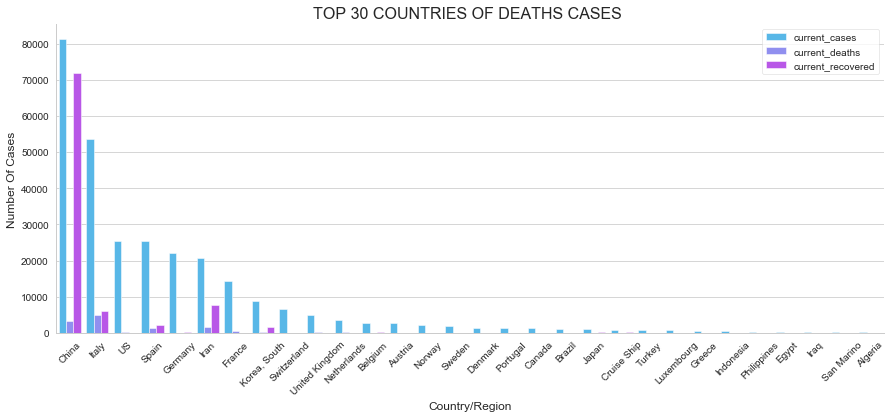

In [96]:
df9 = df7[df7['Country/Region'].isin(top_deaths_list) ]
df9.head()

sns.set_style('whitegrid')
g = sns.catplot(data=df9, x='Country/Region', y='Number Of Cases',
                           hue='Types', kind="bar", palette='cool', height=5, aspect = 2.5, legend = False)
plt.title('TOP 30 COUNTRIES OF DEATHS CASES ', size=16)
plt.legend(loc='upper right');
g.set_xticklabels(rotation=45);

In [97]:
# df8_population = df_2020[df_2020['Location'].isin(top_confirmed_list)]
# df8_population.head()

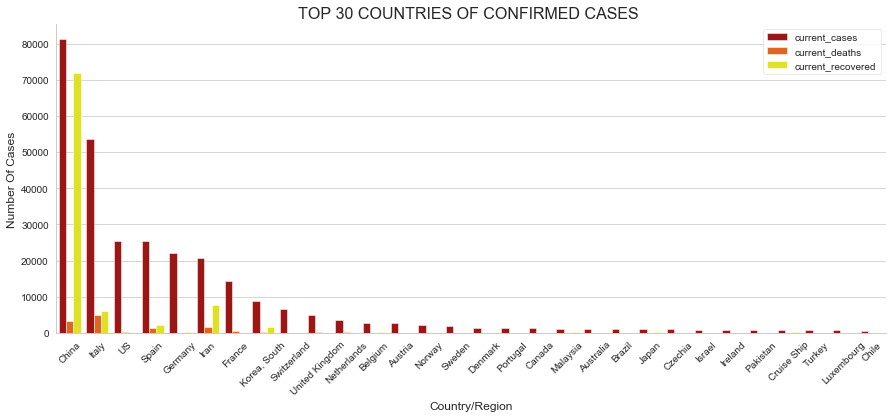

In [98]:
sns.set_style('whitegrid')
g = sns.catplot(data=df8, x='Country/Region', y='Number Of Cases',
                           hue='Types', kind="bar", palette='hot', height=5, aspect = 2.5, legend = False)
plt.title('TOP 30 COUNTRIES OF CONFIRMED CASES ', size=16)
plt.legend(loc='upper right');
g.set_xticklabels(rotation=45);

In [99]:
# df10_population = df_2020[df_2020['Location'].isin(top_recovered_list)]
# df10_population.head()

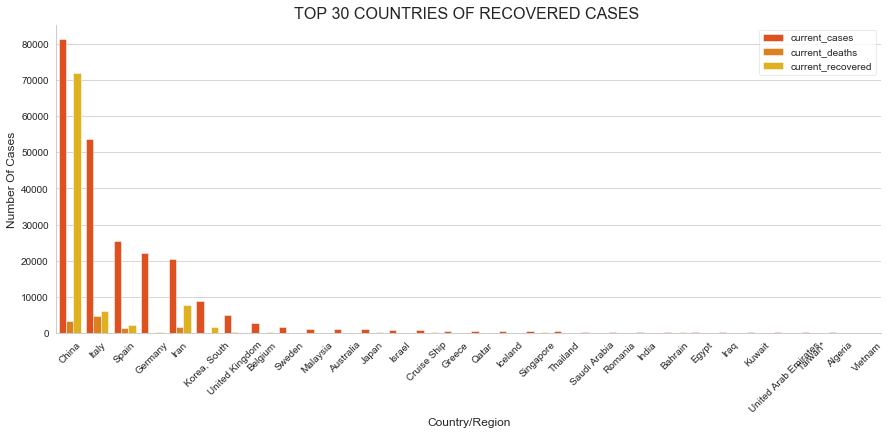

In [100]:
df10 = df7[df7['Country/Region'].isin(top_recovered_list) ]
df10.head()

sns.set_style('whitegrid')
g = sns.catplot(data=df10, x='Country/Region', y='Number Of Cases',
                           hue='Types', kind="bar", palette='autumn', height=5, aspect = 2.5, legend = False)
plt.title('TOP 30 COUNTRIES OF RECOVERED CASES ', size=16)
plt.legend(loc='upper right');
g.set_xticklabels(rotation=45);

In [101]:
# top30_recovered.reset_index(inplace = True)
# sns.set_style('whitegrid')
# g = sns.catplot(x='Country/Region', y='current_recovered', data=top30_recovered,
#                 kind='bar', palette='autumn', height=6, aspect=2.5, legend = False)
# plt.legend(loc='upper right');
# g.set_xticklabels(rotation=45);

### STEP 5: MELTING DATA & MERGING DATA

In [102]:
def melt_data(df):
    """
    melt data of one zip code from wide format to long format
    """
    
    melted = pd.melt(df, id_vars=['Country/Region'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    #melted = melted.dropna(subset=['value'])
    
    return melted.groupby('time').aggregate({'value':'mean'})

In [103]:
def melt_df(df):
    """
    Loop through all zipcodes to melt data of each zipcode.
    Then, merge all melted data back together
    """
    
    merged = []
    for country in df['Country/Region']:
        melted = melt_data(df.loc[df['Country/Region'] == country])
        row = df.loc[df['Country/Region'] == country].iloc[:,:1]
        rows = pd.concat([row]*len(melted), ignore_index=True)
        merge = pd.concat([rows, melted.reset_index()], axis= 1)
        merged.append(merge)
    melted_df = pd.concat(merged)
    return melted_df

In [104]:
sorted_df_confirmed.reset_index(inplace=True)

In [105]:
sorted_df_confirmed.head()

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
0,Afghanistan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24
1,Albania,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76
2,Algeria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139
3,Andorra,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88
4,Angola,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2


In [106]:
df = melt_df(sorted_df_confirmed)

In [107]:
df.head()

,Country/Region,time,value
0,Afghanistan,2020-01-22,0
1,Afghanistan,2020-01-23,0
2,Afghanistan,2020-01-24,0
3,Afghanistan,2020-01-25,0
4,Afghanistan,2020-01-26,0


In [108]:
# check any columns has na/nan value, if there is missing data
#### forward fill missing value
#df['time'] = df['time'].ffill()
df.isnull().any()

Country/Region    False
time              False
value             False
dtype: bool

We see there are some missing data in time and value column. We need to fill these data.

In [109]:
# make it as time series
df.set_index('time', inplace=True)

In [110]:
# look at the head again
df.head()

,Country/Region,value
time,,
2020-01-22,Afghanistan,0
2020-01-23,Afghanistan,0
2020-01-24,Afghanistan,0
2020-01-25,Afghanistan,0
2020-01-26,Afghanistan,0


In [111]:
# check any columns has na/nan value, if there is missing data
df.isnull().any()

Country/Region    False
value             False
dtype: bool

We see value column has missing data
It’s often useful to be able to fill missing data with realistic values such as the average of a time period. However, if we are working with a time series problem and we really want our data to be realistic, we wouldn't want to do a backfill of our data since that’s like looking into the future and getting information you would never have at that time period. We are going to do forward fill our data as follow.

In [112]:
# rename columns
df.rename(columns={'Country/Region': 'Country'}, inplace=True)
df.head()

,Country,value
time,,
2020-01-22,Afghanistan,0
2020-01-23,Afghanistan,0
2020-01-24,Afghanistan,0
2020-01-25,Afghanistan,0
2020-01-26,Afghanistan,0


# Step 2: EDA and Visualization

In [113]:
# countries affected
countries = df['Country'].unique()
len(countries)

166

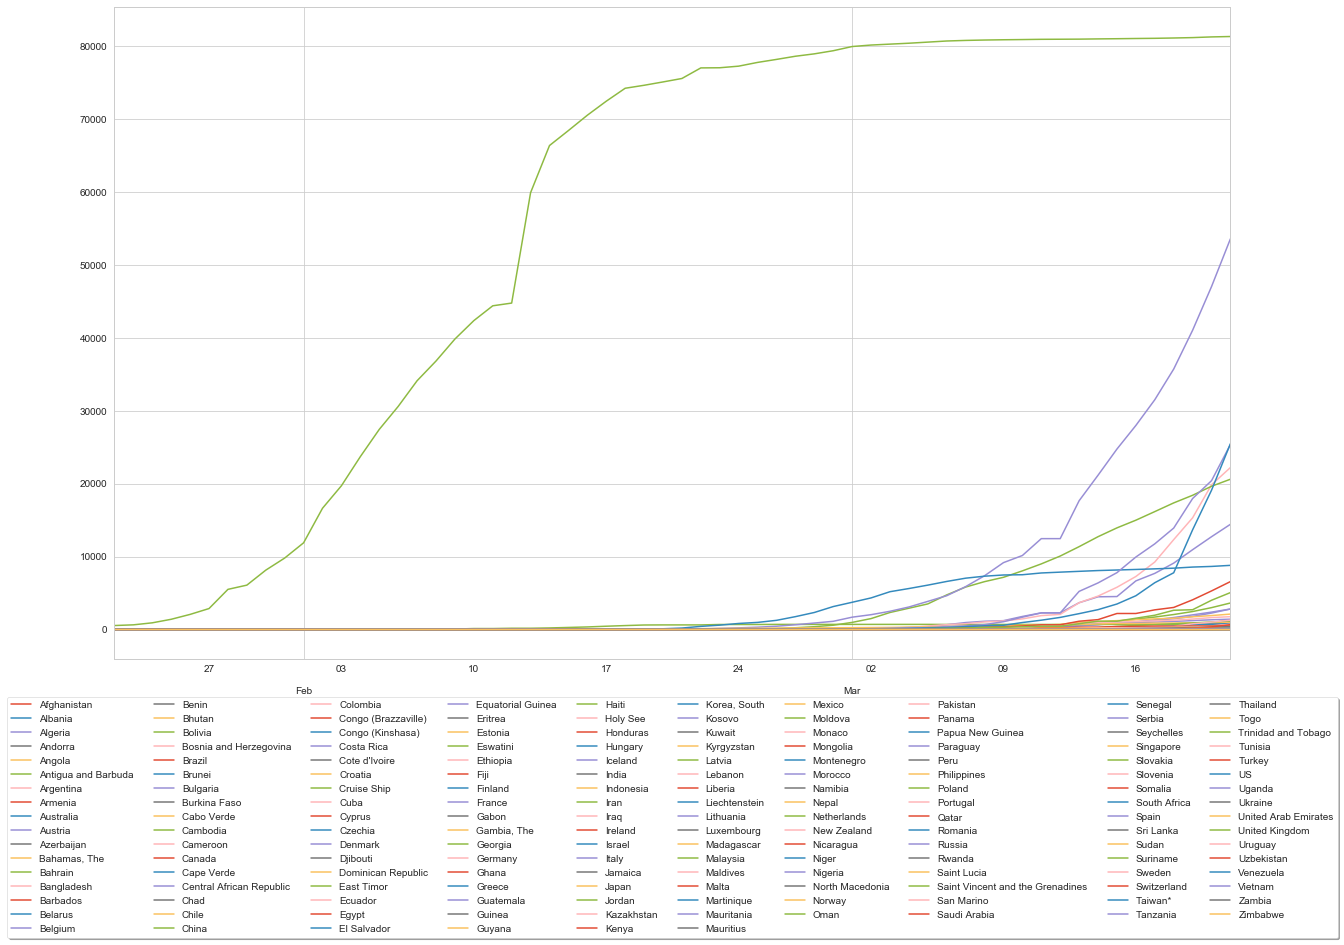

In [114]:
plt.figure(figsize=(20,12))

for c in countries:
    df[df['Country']==c]['value'].plot(label=c)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=10)
plt.show()

### From a quick plot above, we see that the corona virus had started and spreaded widely from China since Jan 22, 2020. There are some countries had started slightly from Feb 20 and the corona virus were actually growing much faster over time. Jan 26, 2020 the spreading speed has increased significantly in some countries such as Singapore, Spain, Iran, Italy . Mar 10, 2020 the corona virus has been spreading out crazily in other countries while there is no new confirmed case. 

##### Compare in 3 bar graphs, top30 of current_cases, top30 of current_deaths, top30 of current_recovered.
##### Each graph has 3 color bars show data of 3 current information

### STEP 8: USE ARIMA TO PREDICT TIME SERIES DATA
#### Since we don't have enough data to check if it has seasonal trend  therefore we don't have to check seasonal trend.

### STEP 9: DEEP LEARNING - CONVOLUTIONAL NEURAL NETWORK (CNN) - TO PREDICT

### STEP 10: 